# Permutation Feature Importance

In this assignment, you'll evaluate feature importance using permutation.

First, you will estimate feature importance using a random forests. 

Next, you'll estimate feature importance using any of the libraries that we covered in this section.

Finally, you will use permutation feature importance to select features recursively.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from feature_engine.selection import SelectByShuffling

from eli5.sklearn import PermutationImportance

## Load data

In [2]:
variables = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
             'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1',
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',  '1stFlrSF',
             '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
             'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
             'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
             'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
             '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
             'MoSold', 'YrSold', 'SalePrice']

In [3]:
# load dataset

data = pd.read_csv('../../houseprice.csv', usecols=variables)

data.shape

(1460, 34)

In [4]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 33), (438, 33))

## Random Forests

In [5]:
# Train Random Forests

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    random_state=2909,)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, random_state=2909)

In [6]:
# R2 in train set

rf.score(X_train, y_train)

0.8078308037529935

In [7]:
# R2 in test set

rf.score(X_test, y_test)

0.780510833461595

## Tree derived feature importance

Extract and plot the importance derived from the random forests. Which features are more important?

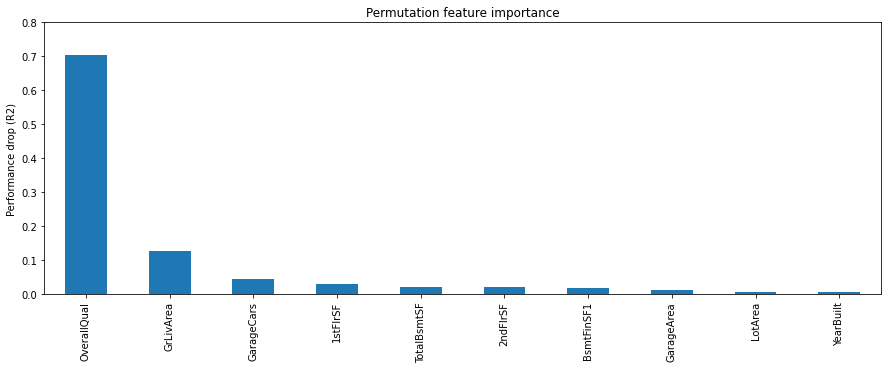

In [8]:
# 10 most important features

pd.Series(
    rf.feature_importances_,
    index=rf.feature_names_in_,
).sort_values(
    ascending=False
).head(10).plot.bar(figsize=(15, 5))

plt.title("Permutation feature importance")
plt.ylabel("Performance drop (R2)")
plt.ylim(0, 0.8)
plt.show()

The most important features are the overall quality, the area of the house, and the number of garages.

## Permutation Feature Importance

Calculate and plot feature importance by permutation. Use any Python library you like.

I use Feature-engine.

The exact values that we obtain may vary due to different seeds or implementations. The order of the features, however, should be roughly the same.

In [9]:
sel = SelectByShuffling(
    variables=None,  # automatically examine all numerical variables
    estimator=rf,  # the ML model
    scoring='r2',  # the metric to evaluate
    threshold=0.01,  # the maximum performance drop allowed to select the feature
    cv=3,  # cross-validation
    random_state=1  # seed
)

sel.fit(X_train, y_train)

SelectByShuffling(estimator=RandomForestRegressor(max_depth=3,
                                                  random_state=2909),
                  random_state=1, scoring='r2', threshold=0.01)

In [10]:
# full model performance

sel.initial_model_performance_

0.7606492527531618

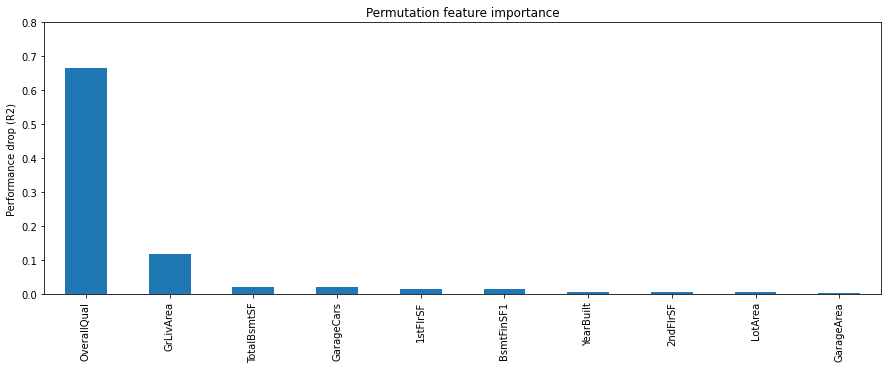

In [11]:
# 10 most important features

pd.Series(sel.performance_drifts_).sort_values(
    ascending=False).head(10).plot.bar(figsize=(15, 5))

plt.title("Permutation feature importance")
plt.ylabel("Performance drop (R2)")
plt.ylim(0, 0.8)
plt.show()

Without surprise, the importance derived from permutation, coincides with that derived from the decision tree.


## Permutation with RFE

We will now use permutation importance to select features, but we will do it recursively.

Tasks:

- implement recursive feature elimination using permutation (you'll need to combine Eli5 and sklearn)
- plot the importance of the selected features
- draw some conclusion

In [12]:
# set up the permutation class from eli

# we already fit the estimator
perm = PermutationImportance(
    rf,
    scoring="r2",
    n_iter=3,  # number of times each feature is shuffled
    cv=3,
    random_state=5,
)

In [13]:
# Set up the recursive feature selection class from
# sklearn

sel = RFE(
    perm,
    n_features_to_select=10,
).set_output(transform="pandas")

In [14]:
# Find important features, recursively
# This may take a while ...

sel.fit(X_train, y_train)

RFE(estimator=PermutationImportance(cv=3,
                                    estimator=RandomForestRegressor(max_depth=3,
                                                                    random_state=2909),
                                    n_iter=3, random_state=5, scoring='r2'),
    n_features_to_select=10)

In [15]:
# the selected features

sel.get_feature_names_out()

array(['OverallQual', 'YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageCars',
       'GarageArea'], dtype=object)

In [16]:
# The importance of the selected features

sel.estimator_.feature_importances_

array([0.65212388, 0.00602444, 0.01303279, 0.01848436, 0.01820355,
       0.00536866, 0.12977911, 0.00410948, 0.01883877, 0.01019038])

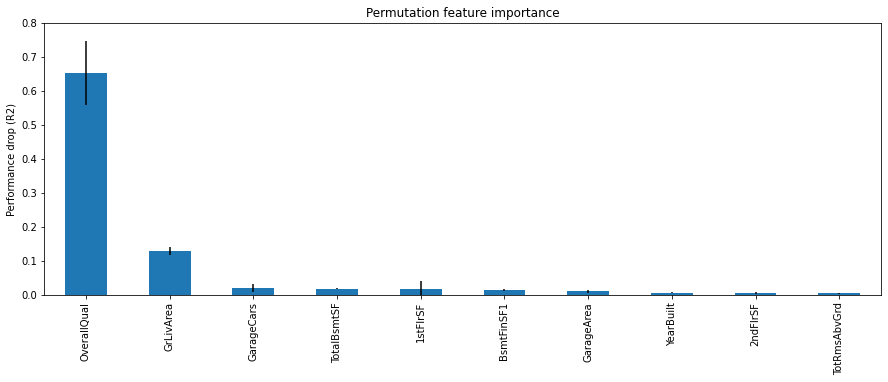

In [17]:
# plot importance of selected features

importance = pd.DataFrame({
    "importance": sel.estimator_.feature_importances_,
    "std": sel.estimator_.feature_importances_std_,
    },
    index = list(sel.get_feature_names_out())
)

# plot manually

importance["importance"].sort_values(
    ascending=False
).plot(figsize=(15, 5), kind="bar", yerr=importance["std"])

plt.title("Permutation feature importance")
plt.ylabel("Performance drop (R2)")
plt.ylim(0, 0.8)
plt.show()

That's it. This is fairly simple dataset, so there is nothing super exciting happening here.